# Gesture Recognition


**Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

In [1]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 20

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))
def normalizeImage(image):
    # applying normalization
    return image/255.0
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)    
    

In [5]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [6]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [8]:
def getImgTensor(n_frames,dim):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, dim, dim, 3]

# define image tensor size
img_tensor = getImgTensor(10,100)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  3,  6, 10, 13, 16, 19, 23, 26, 29]), 100, 100, 3]


### Generator Validation

In [9]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /home/datasets/Project_data/train ; batch size = 20
(20, 10, 100, 100, 3)
Source path =  /home/datasets/Project_data/val ; batch size = 20
(20, 10, 100, 100, 3)


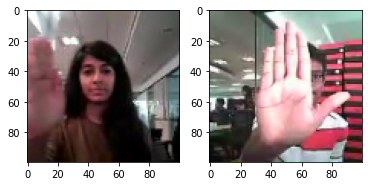

In [10]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,9,:,:,:])   
ax[1].imshow(sample_val_batch_data[11,9,:,:,:])
plt.show()

In [11]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

## Model Building
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model Callbacks Setup

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D,SimpleRNNCell
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]
#callbacks_list = [LR]

In [14]:
img_tensor

[array([ 0,  3,  6, 10, 13, 16, 19, 23, 26, 29]), 100, 100, 3]

### Base Model

In [15]:
#write your model here
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential()
    
    model.add(Conv3D(16,(3,3,3),padding='same',activation='relu',input_shape=inputShape))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(BatchNormalization())

    model.add(Conv3D(32, make3dFilter(3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(BatchNormalization())

    model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(1,2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv3D(128, make3dFilter(3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(1,2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5, activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 50, 50, 16)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 50, 50, 16)     64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 50, 50, 32)     13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 25, 25, 32)     128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 25, 25, 64)     5

In [16]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Test Batch Size & Frames

In [18]:
model = defineModel(img_tensor)
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.5366 - categorical_accuracy: 0.4419Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 703.82806, saving model to model_init_2021-06-0116_05_19.104300/model-00001-1.53660-0.44193-703.82806-0.23000.h5
34/34 [==============================] - 56s 2s/step - loss: 1.5366 - categorical_accuracy: 0.4419 - val_loss: 703.8281 - val_categorical_accuracy: 0.2300
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.8749 - categorical_accuracy: 0.3039
Epoch 00002: val_loss improved from 703.82806 to 88.54144, saving model to model_init_2021-06-0116_05_19.104300/model-00002-1.87492-0.30392-88.54144-0.23000.h5
34/34 [==============================] - 17s 514ms/step - loss: 1.8749 - categorical_accuracy: 0.3039 - val_l

#### By base model we confirmed data accesibility and working of model

### Model 1 - Frames-20, Epoc-25, batch-40 -  increasing layers to increase efficiency

In [19]:
n_frames = 20

batch_size = 40

img_tensor = getImgTensor(n_frames,120)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model = Sequential(name="conv_3d1")

model.add(Conv3D(16,make3dFilter(5),padding='same',activation='relu',input_shape=inputShape))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(16,make3dFilter(5),padding='same',activation='relu',input_shape=inputShape))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(32, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())
    
model.add(Conv3D(128, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax')) 

model.compile(optimizer=optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

Model: "conv_3d1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 120, 120, 16)  6016      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 60, 60, 16)    64        
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 60, 60, 16)    32016     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 5, 30, 30, 16)     0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 5, 30, 30, 16)     64        
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 5, 30, 30, 32)     138

In [20]:
num_epochs = 25
model1_history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.9139 - categorical_accuracy: 0.3107Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss did not improve from 1.69577
17/17 [==============================] - 110s 6s/step - loss: 1.9139 - categorical_accuracy: 0.3107 - val_loss: 5.7341 - val_categorical_accuracy: 0.2200
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.2625 - categorical_accuracy: 0.4936
Epoch 00002: val_loss did not improve from 1.69577
17/17 [==============================] - 65s 4s/step - loss: 1.2625 - categorical_accuracy: 0.4936 - val_loss: 2.2492 - val_categorical_accuracy: 0.2500
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.3175 - categorical_accuracy: 0.5204
Epoch 00003: val_loss did not improve from 1.69577
17/17 [==============================] - 65s 4s/step - loss: 1.3175 - categorical_accuracy

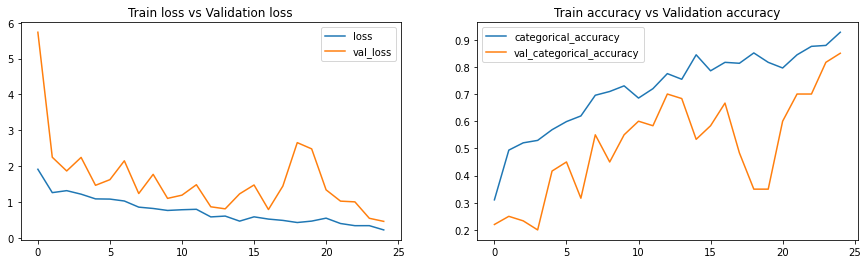

Max. Training Accuracy 0.9273356199264526
Max. Validaiton Accuracy 0.8500000238418579


In [21]:
plotModelHistory(model1_history)

### Frames-20, Epoc-30, batch-40 - adding more layers and increasing number of epoc to increase effeciency

In [22]:
n_frames = 20

batch_size = 40

img_tensor = getImgTensor(n_frames,120)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model = Sequential(name="conv_3d1")

model.add(Conv3D(16,make3dFilter(5),padding='same',activation='relu',input_shape=inputShape))

model.add(Conv3D(16,make3dFilter(5),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))
model.add(BatchNormalization())

model.add(Conv3D(32, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))
model.add(BatchNormalization())

model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))


model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2),padding='same'))
model.add(BatchNormalization())
    
model.add(Conv3D(128, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2),padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax')) 

model.compile(optimizer=optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

Model: "conv_3d1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 120, 120, 16)  6016      
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 20, 120, 120, 16)  32016     
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 60, 60, 16)    64        
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 5, 30, 30, 32)     128

In [23]:
num_epochs = 30
model2_history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.5928 - categorical_accuracy: 0.4133Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss did not improve from 0.46106
17/17 [==============================] - 111s 7s/step - loss: 1.5928 - categorical_accuracy: 0.4133 - val_loss: 7.3540 - val_categorical_accuracy: 0.2500
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.3504 - categorical_accuracy: 0.4783
Epoch 00002: val_loss did not improve from 0.46106
17/17 [==============================] - 69s 4s/step - loss: 1.3504 - categorical_accuracy: 0.4783 - val_loss: 43.3466 - val_categorical_accuracy: 0.3000
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.5147 - categorical_accuracy: 0.4714
Epoch 00003: val_loss did not improve from 0.46106
17/17 [==============================] - 69s 4s/step - loss: 1.5147 - categorical_accurac

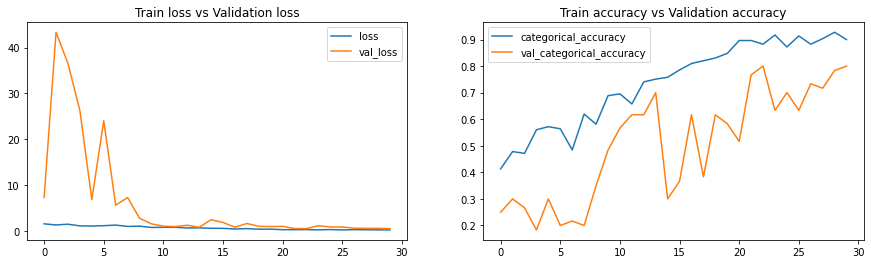

Max. Training Accuracy 0.9273356199264526
Max. Validaiton Accuracy 0.800000011920929


In [24]:
plotModelHistory(model2_history)

Reduce batch size to make model fast

### Model 3: Frames-20, Epocs-25,batch=35

In [25]:
n_frames = 20

batch_size = 35

img_tensor = getImgTensor(n_frames,120)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model = Sequential(name="conv_3d3")

model.add(Conv3D(16,make3dFilter(5),padding='same',activation='relu',input_shape=inputShape))

model.add(Conv3D(16,make3dFilter(5),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))
model.add(BatchNormalization())

model.add(Conv3D(32, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))
model.add(BatchNormalization())

model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))


model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2),padding='same'))
model.add(BatchNormalization())
    
model.add(Conv3D(128, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2),padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax')) 

model.compile(optimizer=optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

Model: "conv_3d3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 20, 120, 120, 16)  6016      
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 20, 120, 120, 16)  32016     
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 10, 60, 60, 16)    64        
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 5, 30, 30, 32)     128

In [26]:
num_epochs = 25
model3_history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 35
Epoch 1/25
19/19 [==============================] - ETA: 0s - loss: 1.6952 - categorical_accuracy: 0.3906Source path =  /home/datasets/Project_data/val ; batch size = 35

Epoch 00001: val_loss did not improve from 0.46106
19/19 [==============================] - 122s 6s/step - loss: 1.6952 - categorical_accuracy: 0.3906 - val_loss: 4.2510 - val_categorical_accuracy: 0.2500
Epoch 2/25
19/19 [==============================] - ETA: 0s - loss: 1.2135 - categorical_accuracy: 0.5343
Epoch 00002: val_loss did not improve from 0.46106
19/19 [==============================] - 99s 5s/step - loss: 1.2135 - categorical_accuracy: 0.5343 - val_loss: 9.0153 - val_categorical_accuracy: 0.1714
Epoch 3/25
19/19 [==============================] - ETA: 0s - loss: 1.8425 - categorical_accuracy: 0.3563
Epoch 00003: val_loss did not improve from 0.46106
19/19 [==============================] - 14s 719ms/step - loss: 1.8425 - categorical_accur

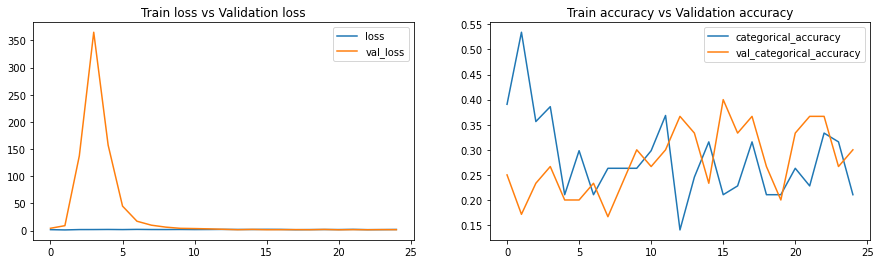

Max. Training Accuracy 0.5342902541160583
Max. Validaiton Accuracy 0.4000000059604645


In [27]:
plotModelHistory(model3_history)

### Model 4: Frames-20, batch-40, image size-100X100 and reduced parmeters

In [28]:
n_frames = 20

batch_size = 40

img_tensor = getImgTensor(n_frames,100)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model = Sequential(name="conv_3d3")

model.add(Conv3D(16,make3dFilter(5),padding='same',activation='relu',input_shape=inputShape))

model.add(Conv3D(16,make3dFilter(5),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))
model.add(BatchNormalization())

model.add(Conv3D(32, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))
model.add(BatchNormalization())

model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))
model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2),padding='same'))
model.add(BatchNormalization())
    
model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2),padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax')) 

model.compile(optimizer=optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

Model: "conv_3d3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 20, 100, 100, 16)  6016      
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 20, 100, 100, 16)  32016     
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 10, 50, 50, 16)    64        
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 5, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 5, 25, 25, 32)     128

In [29]:
num_epochs = 35
model4_history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/35
17/17 [==============================] - ETA: 0s - loss: 1.7260 - categorical_accuracy: 0.3469Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss did not improve from 0.46106
17/17 [==============================] - 108s 6s/step - loss: 1.7260 - categorical_accuracy: 0.3469 - val_loss: 23.2305 - val_categorical_accuracy: 0.2600
Epoch 2/35
17/17 [==============================] - ETA: 0s - loss: 1.3893 - categorical_accuracy: 0.4194
Epoch 00002: val_loss did not improve from 0.46106
17/17 [==============================] - 68s 4s/step - loss: 1.3893 - categorical_accuracy: 0.4194 - val_loss: 13.8205 - val_categorical_accuracy: 0.2500
Epoch 3/35
17/17 [==============================] - ETA: 0s - loss: 1.2696 - categorical_accuracy: 0.5068
Epoch 00003: val_loss did not improve from 0.46106
17/17 [==============================] - 64s 4s/step - loss: 1.2696 - categorical_accura

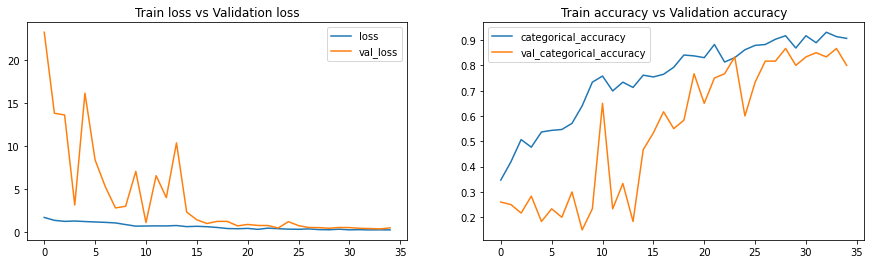

Max. Training Accuracy 0.9307958483695984
Max. Validaiton Accuracy 0.8666666746139526


In [30]:
plotModelHistory(model4_history)

### Model 5: Frames:24, Epocs-20, BS-40, switching BatchNormalization before MaxPooling and reducing trainable parameters

In [31]:
n_frames = 24

batch_size = 40

img_tensor = getImgTensor(n_frames,100)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model = Sequential(name="conv_3d3")

model.add(Conv3D(16,make3dFilter(5),padding='same',activation='relu',input_shape=inputShape))
model.add(BatchNormalization())
#model.add(Conv3D(16,make3dFilter(5),padding='same',activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))

#model.add(Conv3D(32, make3dFilter(3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(Conv3D(32, make3dFilter(3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))

#model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))

    
model.add(Conv3D(64, make3dFilter(3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))


model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax')) 

model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

Model: "conv_3d3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_31 (Conv3D)           (None, 24, 100, 100, 16)  6016      
_________________________________________________________________
batch_normalization_39 (Batc (None, 24, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 12, 50, 50, 16)    0         
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 12, 50, 50, 32)    13856     
_________________________________________________________________
batch_normalization_40 (Batc (None, 12, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 6, 25, 25, 32)     0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 6, 25, 25, 64)     553

In [32]:
num_epochs = 35
model5_history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/35
17/17 [==============================] - ETA: 0s - loss: 1.8093 - categorical_accuracy: 0.3952Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss did not improve from 0.39421
17/17 [==============================] - 131s 8s/step - loss: 1.8093 - categorical_accuracy: 0.3952 - val_loss: 3.7520 - val_categorical_accuracy: 0.2300
Epoch 2/35
17/17 [==============================] - ETA: 0s - loss: 1.3288 - categorical_accuracy: 0.5269
Epoch 00002: val_loss did not improve from 0.39421
17/17 [==============================] - 79s 5s/step - loss: 1.3288 - categorical_accuracy: 0.5269 - val_loss: 1.6852 - val_categorical_accuracy: 0.2500
Epoch 3/35
17/17 [==============================] - ETA: 0s - loss: 1.1681 - categorical_accuracy: 0.5722
Epoch 00003: val_loss did not improve from 0.39421
17/17 [==============================] - 78s 5s/step - loss: 1.1681 - categorical_accuracy

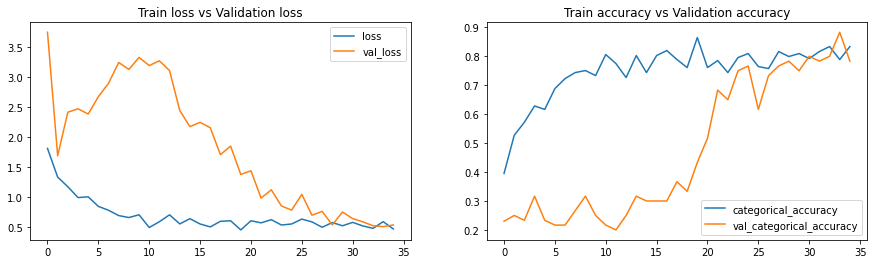

Max. Training Accuracy 0.8650519251823425
Max. Validaiton Accuracy 0.8833333253860474


In [33]:
plotModelHistory(model5_history)

### Model 6: Switching Model architecture to Conv2D+LSTM

In [34]:
n_frames = 20
num_epochs = 30
batch_size = 40


img_tensor = getImgTensor(n_frames,120)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),
    

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),
  

    TimeDistributed(Conv2D(64, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),
    
    
    TimeDistributed(Conv2D(128, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),
    
    TimeDistributed(Conv2D(256, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),
    
    TimeDistributed(Flatten()),
    
    LSTM(128),
    Dropout(0.25),

    Dense(128, activation='relu'),
    
    Dropout(0.25),
    

    Dense(5, activation='softmax')
    
], name="conv_2d_lstm")
model6.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 64)   

In [35]:
model6_history = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 60
Epoch 1/25
12/12 [==============================] - ETA: 0s - loss: 1.3863 - categorical_accuracy: 0.4284 Source path =  /home/datasets/Project_data/val ; batch size = 60

Epoch 00001: val_loss did not improve from 0.39421
12/12 [==============================] - 161s 13s/step - loss: 1.3863 - categorical_accuracy: 0.4284 - val_loss: 1.5997 - val_categorical_accuracy: 0.3400
Epoch 2/25
12/12 [==============================] - ETA: 0s - loss: 1.4364 - categorical_accuracy: 0.5278
Epoch 00002: val_loss did not improve from 0.39421
12/12 [==============================] - 28s 2s/step - loss: 1.4364 - categorical_accuracy: 0.5278 - val_loss: 1.5855 - val_categorical_accuracy: 0.3167
Epoch 3/25
12/12 [==============================] - ETA: 0s - loss: 1.6197 - categorical_accuracy: 0.1389
Epoch 00003: val_loss did not improve from 0.39421
12/12 [==============================] - 22s 2s/step - loss: 1.6197 - categorical_accura

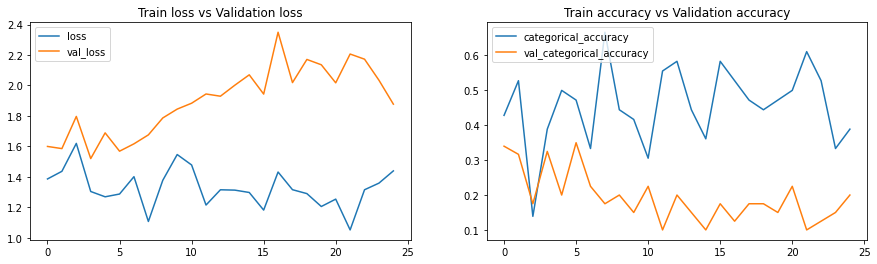

Max. Training Accuracy 0.6666666865348816
Max. Validaiton Accuracy 0.3499999940395355


In [36]:
plotModelHistory(model6_history)

### Model 7: Transfer Learning (MobileNet) with LSTM

In [37]:
from tensorflow.keras.applications import mobilenet

In [38]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 24
num_epochs = 35
batch_size = 40

img_tensor = getImgTensor(n_frames,100)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model7.layers:
    layer.trainable = False

model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D(make2dFilter(2),padding='same')))
model7.add(TimeDistributed(Flatten()))

model7.add(LSTM(256))
model7.add(Dropout(0.5))

model7.add(Dense(128,activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(5, activation='softmax'))

model7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

model7_history = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

17227776/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 24, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_17 (TimeDis (None, 24, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 24, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 24, 4096)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               4457472   
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_____________________________________________________

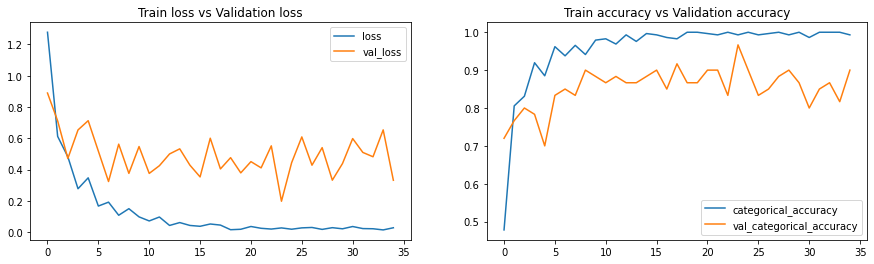

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.9666666388511658


In [39]:
plotModelHistory(model7_history)